In [58]:
# --- Standard libraries
import os
import copy
import re
import json
import codecs
import numpy as np
import pandas as pd
from natsort import natsorted
# --- Bokeh
from bokeh.io import output_notebook, show, export_png, export_svg
from bokeh.plotting import figure
output_notebook()
# --- ASE
from ase.io import read
# --- RDKit
import rdkit
from rdkit import Chem
from rdkit.Chem.rdmolfiles import MolFromXYZFile
from rdkit.Chem import rdDetermineBonds
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.drawOptions.addAtomIndices=True
IPythonConsole.drawOptions.annotationFontScale=0.8
IPythonConsole.molSize = 400,400
rdkit.__version__

Loading BokehJS ...

'2024.03.1'

### Code functions

In [21]:
def rearrange_xyz(path, filename):

    '''
    Function that rearranges the given .xyz file to move all the
    oxygen and hydrogen atoms to the bottom of the file
    '''

    # --- Open the original .xyz file and parse the lines with
    # --- O and H coordinates to lists
    with open(os.path.join(path, filename), 'r') as fr:
        lines = fr.readlines()
        o_lines = []
        h_lines = []

        for line in lines:
            if line.startswith('  O'):
                o_lines.append(line)
            elif line.startswith('  H'):
                h_lines.append(line)

        # --- Open the .xyz file to write
        with open(os.path.join(path, filename), 'w') as fw:

            # --- Write all lines that are not O or H coordinates
            for line in lines:
                if line.startswith('  H'):
                    pass
                elif line.startswith('  O'):
                    pass
                else:
                    fw.write(line)
        
            # --- Write O coordinates
            for x in o_lines:
                fw.write(x)

            # --- Write H coordinates
            for y in h_lines:
                fw.write(y)

In [22]:
def create_mol_from_xyz(path):

    '''
    Take in the path of a .xyz file and use
    RDKit to create a mol object and SMILES string
    '''

    # --- Read in and create RDkit mol variable
    raw_mol = MolFromXYZFile(path)
    rdDetermineBonds.DetermineBonds(raw_mol)
    #mol = Chem.RemoveAllHs(raw_mol)
    mol = raw_mol
    Chem.RemoveStereochemistry(mol)

    xyz_dict = {}
    ase_go = read(path)
    pos = ase_go.get_positions()

    # --- RDKit index given by the order in the XYZ file but
    # --- this changes when reading the SMILES string to a new atom
    # --- indexing.
    for i, atom in enumerate(mol.GetAtoms()):
        atom.SetAtomMapNum(atom.GetIdx())
        xyz_dict[atom.GetIdx()] = list(pos[i])

    # --- Create SMILES and SMARTS strings
    smi = Chem.MolToSmiles(mol)

    # --- Load a new RDKit mol to get new RDKit atom indexes
    new_mol = Chem.MolFromSmiles(smi)
    # --- Create dictionaries to store information
    idx_dict = {}
    map_num = {}
    new_xyz = {}

    # --- Loop over all atoms in the molecule
    for atom in new_mol.GetAtoms():
        # --- Create dictionary linking mapnum to atom index
        map_num[atom.GetAtomMapNum()] = atom

    # --- Sort the dictionary in numerical order
    sort_map = sorted(map_num)

    # --- Loop over all atoms in the molecule with respect to map number
    for num in sort_map:
        # --- If atom is a carbon
        if map_num[num].GetAtomicNum() == 6:
            # --- Get the RDkit atom index and store into new dictionary
            rd_idx = map_num[num].GetIdx()
            idx_dict[num] = rd_idx#, xyz_dict[num], map_num[num].GetAtomicNum()

        rdk_idx = map_num[num].GetIdx()
        new_xyz[rdk_idx] = num, xyz_dict[num], map_num[num].GetAtomicNum()
    
    z = []
    pos = np.zeros([len(new_xyz), 3])

    for i in range(len(new_xyz)):
        z_temp = new_xyz[i][2]
        z.append(z_temp)

        for x in range(3):
            pos_temp = new_xyz[i][1]
            pos[i, x] = pos_temp[x]

    return new_mol, smi, idx_dict, pos, z

In [23]:
def broaden_spectrum(E, osc, x, sigma):

    '''
    Take the delta peaks of a XAS spectrum and applies
    a Gaussian broadening scheme
    '''

    gE = []

    # --- Apply Gaussian broadening
    for Ei in x:
        tot = 0
        for Ej, os in zip(E, osc):
            tot += os * np.exp(-((((Ej - Ei) / sigma) ** 2)))
        gE.append(tot)
    
    return gE

In [24]:
def count_atoms(mol, atomic_num):

    '''
    Count the number of a specific atom in 
    a molecule using RDKit
    '''

    num_atoms = 0
    for atom in mol.GetAtoms():
        if atom.GetAtomicNum() == atomic_num:
            num_atoms += 1
    
    return num_atoms

In [25]:
def create_spec_dict(main_dir):

    '''
    Create a python dictionary for a molecule with atom indexes
    as keys and the individual spectrum as the value
    '''

    # --- Create x-axis array to plot data with
    x = np.linspace(280, 300, num=200, endpoint=True)
    sigma = 0.6

    # --- List all the possible xyz files
    xyz_files = [f for f in os.listdir(main_dir) if os.path.isfile(os.path.join(main_dir, f))]

    # --- Search for correct optimised XYZ file
    pattern = r'OPT_[\w]+\.xyz$'

    for filename in xyz_files:
        if re.match(pattern, filename):
            xyz_name = filename
            break

    # --- Set a variable for the chosen xyz file
    xyz_path = main_dir + '/' + xyz_name

    # --- Call function to rearrange xyz file atom order
    rearrange_xyz(main_dir, xyz_name)

    # --- Call function to create RDKit mol variable
    mol, smiles, idx_dict, pos, z = create_mol_from_xyz(xyz_path)

    # --- Get all individual atom directories for molecule
    loc_dirs = [os.path.join(main_dir, d) for d in os.listdir(main_dir) if os.path.isdir(os.path.join(main_dir, d))]

    # --- Sort directories in numerical order
    sort_dirs = natsorted(loc_dirs)

    spec_dict = {}

    # --- Loop through all atom directories
    for i in range(len(loc_dirs)):
        loc_dir = sort_dirs[i]
        # --- Loop through and get all files in atom directory
        loc_files = [f for f in os.listdir(loc_dir) if os.path.isfile(os.path.join(loc_dir, f))]

        # --- Loop through all files in directory
        for filename in loc_files:
            # --- Find spectrum .abs.stk file and read data
            if filename.endswith('.abs.stk'):
                spec_df = pd.read_csv(loc_dir + '/' + filename, sep='\s+', header=None, names=['Peaks', 'Strength'])
                # --- Extract the photon energy and oscilator strength
                energies = spec_df['Peaks']
                osc = spec_df['Strength']
                # --- Call function to broaden spectrum
                gE = broaden_spectrum(energies, osc, x, sigma)
                # --- Add to dictionary with RDKit index
                spec_dict[idx_dict[i]] = gE

    return mol, spec_dict, smiles, pos, z

### Start code

In [26]:
# --- Path to main folder where all the data is
#data_path = '../GNN_XAS_Node/raw_data/coronene/OPT_output'
data_path = '../GNN_XAS_Node/raw_data/set_tot/OPT_output'
# --- Create a list with the path of all the different molecule folders
subdirs = [os.path.join(data_path, d) for d in os.listdir(data_path) if os.path.isdir(os.path.join(data_path, d))]

# --- Number of molecules in the data set
print(len(subdirs))
# --- List of paths to all the different molecules
print(subdirs)

317
['../GNN_XAS_Node/raw_data/set_tot/OPT_output/R_eOH_0_eCOOH__1_eEPOXY_2_eCHO_0_eKETO_0_iOH_0_iEPOXY_0_ieEPOXY_1_0', '../GNN_XAS_Node/raw_data/set_tot/OPT_output/R_eOH_0_eCOOH__0_eEPOXY_1_eCHO_0_eKETO_1_iOH_0_iEPOXY_1_ieEPOXY_2_0', '../GNN_XAS_Node/raw_data/set_tot/OPT_output/R_eOH_2_eCOOH__0_eEPOXY_0_eCHO_1_eKETO_0_iOH_0_iEPOXY_0_ieEPOXY_2_1', '../GNN_XAS_Node/raw_data/set_tot/OPT_output/R_eOH_0_eCOOH__0_eEPOXY_1_eCHO_0_eKETO_1_iOH_1_iEPOXY_1_ieEPOXY_1_0', '../GNN_XAS_Node/raw_data/set_tot/OPT_output/R_eOH_1_eCOOH__0_eEPOXY_1_eCHO_0_eKETO_0_iOH_0_iEPOXY_1_ieEPOXY_2_0', '../GNN_XAS_Node/raw_data/set_tot/OPT_output/R_eOH_1_eCOOH__0_eEPOXY_0_eCHO_3_eKETO_0_iOH_0_iEPOXY_0_ieEPOXY_1_2', '../GNN_XAS_Node/raw_data/set_tot/OPT_output/R_eOH_1_eCOOH__0_eEPOXY_0_eCHO_2_eKETO_1_iOH_0_iEPOXY_1_ieEPOXY_0_1', '../GNN_XAS_Node/raw_data/set_tot/OPT_output/R_eOH_1_eCOOH__1_eEPOXY_0_eCHO_0_eKETO_0_iOH_2_iEPOXY_0_ieEPOXY_1_2', '../GNN_XAS_Node/raw_data/set_tot/OPT_output/R_eOH_2_eCOOH__0_eEPOXY_0_eCHO

In [27]:
mol_name = []
# --- Split up into the directory path and list of all the folder/molecule names
for subdir in subdirs:
    dir_path, path = os.path.split(subdir)
    mol_name.append(path)

print(len(mol_name))
# --- List of all the molecule names
print(mol_name)

317
['R_eOH_0_eCOOH__1_eEPOXY_2_eCHO_0_eKETO_0_iOH_0_iEPOXY_0_ieEPOXY_1_0', 'R_eOH_0_eCOOH__0_eEPOXY_1_eCHO_0_eKETO_1_iOH_0_iEPOXY_1_ieEPOXY_2_0', 'R_eOH_2_eCOOH__0_eEPOXY_0_eCHO_1_eKETO_0_iOH_0_iEPOXY_0_ieEPOXY_2_1', 'R_eOH_0_eCOOH__0_eEPOXY_1_eCHO_0_eKETO_1_iOH_1_iEPOXY_1_ieEPOXY_1_0', 'R_eOH_1_eCOOH__0_eEPOXY_1_eCHO_0_eKETO_0_iOH_0_iEPOXY_1_ieEPOXY_2_0', 'R_eOH_1_eCOOH__0_eEPOXY_0_eCHO_3_eKETO_0_iOH_0_iEPOXY_0_ieEPOXY_1_2', 'R_eOH_1_eCOOH__0_eEPOXY_0_eCHO_2_eKETO_1_iOH_0_iEPOXY_1_ieEPOXY_0_1', 'R_eOH_1_eCOOH__1_eEPOXY_0_eCHO_0_eKETO_0_iOH_2_iEPOXY_0_ieEPOXY_1_2', 'R_eOH_2_eCOOH__0_eEPOXY_0_eCHO_0_eKETO_0_iOH_2_iEPOXY_0_ieEPOXY_0_2', 'R_eOH_1_eCOOH__0_eEPOXY_1_eCHO_2_eKETO_0_iOH_1_iEPOXY_0_ieEPOXY_0_2', 'R_eOH_0_eCOOH__2_eEPOXY_0_eCHO_0_eKETO_1_iOH_0_iEPOXY_0_ieEPOXY_0_1', 'R_eOH_0_eCOOH__0_eEPOXY_0_eCHO_0_eKETO_0_iOH_1_iEPOXY_2_ieEPOXY_0_0', 'R_eOH_0_eCOOH__1_eEPOXY_0_eCHO_2_eKETO_0_iOH_1_iEPOXY_1_ieEPOXY_0_1', 'R_eOH_2_eCOOH__0_eEPOXY_1_eCHO_0_eKETO_0_iOH_0_iEPOXY_0_ieEPOXY_1_0', '

In [53]:
# --- Create python dictionaries
spec_dict = {}
mol_dict = {}
smiles_dict = {}

# --- Molecule counter
mol_num = 1

# --- Loop through all the molecule directories
for subdir in subdirs:
    dir_path, mol_name = os.path.split(subdir)
    print(f'Current mol no {mol_num}: {mol_name}')
    mol_num += 1
    # --- Call function to create spectrum dictionary
    mol, spec_list, smiles, pos, z = create_spec_dict(subdir)
    num_carbons = count_atoms(mol, 6)

    # --- Sanity check number of carbons in mol matches
    # --- the number of spectra, if so create dictionaries
    if len(spec_list.keys()) == num_carbons:
        spec_dict[mol_name] = spec_list
        mol_dict[mol_name] = smiles, pos.tolist(), z
    else:
        print('Molecule invalid:', subdir)


Current mol no 1: R_eOH_0_eCOOH__1_eEPOXY_2_eCHO_0_eKETO_0_iOH_0_iEPOXY_0_ieEPOXY_1_0
Current mol no 2: R_eOH_0_eCOOH__0_eEPOXY_1_eCHO_0_eKETO_1_iOH_0_iEPOXY_1_ieEPOXY_2_0
Current mol no 3: R_eOH_2_eCOOH__0_eEPOXY_0_eCHO_1_eKETO_0_iOH_0_iEPOXY_0_ieEPOXY_2_1
Current mol no 4: R_eOH_0_eCOOH__0_eEPOXY_1_eCHO_0_eKETO_1_iOH_1_iEPOXY_1_ieEPOXY_1_0
Current mol no 5: R_eOH_1_eCOOH__0_eEPOXY_1_eCHO_0_eKETO_0_iOH_0_iEPOXY_1_ieEPOXY_2_0
Current mol no 6: R_eOH_1_eCOOH__0_eEPOXY_0_eCHO_3_eKETO_0_iOH_0_iEPOXY_0_ieEPOXY_1_2
Current mol no 7: R_eOH_1_eCOOH__0_eEPOXY_0_eCHO_2_eKETO_1_iOH_0_iEPOXY_1_ieEPOXY_0_1
Current mol no 8: R_eOH_1_eCOOH__1_eEPOXY_0_eCHO_0_eKETO_0_iOH_2_iEPOXY_0_ieEPOXY_1_2
Current mol no 9: R_eOH_2_eCOOH__0_eEPOXY_0_eCHO_0_eKETO_0_iOH_2_iEPOXY_0_ieEPOXY_0_2
Current mol no 10: R_eOH_1_eCOOH__0_eEPOXY_1_eCHO_2_eKETO_0_iOH_1_iEPOXY_0_ieEPOXY_0_2
Current mol no 11: R_eOH_0_eCOOH__2_eEPOXY_0_eCHO_0_eKETO_1_iOH_0_iEPOXY_0_ieEPOXY_0_1
Current mol no 12: R_eOH_0_eCOOH__0_eEPOXY_0_eCHO_0_

In [54]:
# Combine the mol and spectra dictionaries into one variable
data = []

data.append(mol_dict)
data.append(spec_dict)

In [55]:
data[0]['R_eOH_0_eCOOH__0_eEPOXY_0_eCHO_0_eKETO_0_iOH_0_iEPOXY_0_ieEPOXY_3_2'][1]

[[-0.05193217344816, 1.43491939000661, 0.15150474439701],
 [1.21219712924174, 0.75741041621866, 0.06266168491656],
 [2.45092380252873, 1.47773653936587, 0.05200744941872],
 [3.64740119798037, 0.76661133005548, 0.00185508621177],
 [3.66418077380161, -0.64305267780196, -0.04937170516499],
 [2.48403947076915, -1.38079887483179, -0.05466276781329],
 [1.22965380540559, -0.68703294528491, -0.01184900361106],
 [-0.01453999579674, -1.39676094349306, -0.05858687684833],
 [-1.23835855439598, -0.71667676901968, 0.02655015864073],
 [-1.249648219704, 0.71219740802868, 0.17096184398755],
 [-2.55927421566466, 1.42001127908295, 0.33993348680711],
 [-3.79040158225887, 0.63573376305408, 0.12110956258744],
 [-3.75855884894705, -0.70451471412043, -0.07149465733364],
 [-2.51330266629533, -1.46223977016331, -0.06535960222137],
 [-2.52586640740161, -2.82732743947235, -0.10440308784345],
 [-1.27854959651084, -3.63869850355564, 0.03032309975817],
 [-0.01728211098065, -2.86893325743943, -0.31914720098975],
 [1.

In [57]:
# --- Save the data into a json file
json.dump(data, codecs.open('raw/data_coronene_schnet.json', 'w', encoding='utf-8'),
          separators=(',', ':'),
          sort_keys=True,
          indent=4)

In [44]:
# --- Save the data into a json file
with open('raw/data_coronene_schnet.json', 'w') as j_file:
    json.dump(data, j_file)

### Check saved data

In [45]:
with open('raw/data_coronene_new.json', 'r') as j_file:
    data = json.load(j_file)

In [46]:
# --- Load all the molecule names from keys of first dictionary
keys = []

for i in data[0].keys():
    keys.append(i)

print(keys)

['R_eOH_0_eCOOH__0_eEPOXY_0_eCHO_0_eKETO_0_iOH_0_iEPOXY_0_ieEPOXY_3_2', 'R_eOH_0_eCOOH__0_eEPOXY_0_eCHO_0_eKETO_0_iOH_0_iEPOXY_1_ieEPOXY_1_1', 'R_eOH_0_eCOOH__0_eEPOXY_0_eCHO_0_eKETO_0_iOH_0_iEPOXY_1_ieEPOXY_4_1', 'R_eOH_0_eCOOH__0_eEPOXY_0_eCHO_0_eKETO_0_iOH_0_iEPOXY_2_ieEPOXY_1_0', 'R_eOH_0_eCOOH__0_eEPOXY_0_eCHO_0_eKETO_0_iOH_0_iEPOXY_3_ieEPOXY_1_2', 'R_eOH_0_eCOOH__0_eEPOXY_0_eCHO_0_eKETO_0_iOH_1_iEPOXY_0_ieEPOXY_1_2', 'R_eOH_0_eCOOH__0_eEPOXY_0_eCHO_0_eKETO_0_iOH_1_iEPOXY_0_ieEPOXY_4_0', 'R_eOH_0_eCOOH__0_eEPOXY_0_eCHO_0_eKETO_0_iOH_1_iEPOXY_2_ieEPOXY_0_0', 'R_eOH_0_eCOOH__0_eEPOXY_0_eCHO_0_eKETO_0_iOH_1_iEPOXY_2_ieEPOXY_1_2', 'R_eOH_0_eCOOH__0_eEPOXY_0_eCHO_0_eKETO_0_iOH_2_iEPOXY_3_ieEPOXY_0_2', 'R_eOH_0_eCOOH__0_eEPOXY_0_eCHO_0_eKETO_0_iOH_3_iEPOXY_0_ieEPOXY_1_1', 'R_eOH_0_eCOOH__0_eEPOXY_0_eCHO_0_eKETO_0_iOH_3_iEPOXY_1_ieEPOXY_0_0', 'R_eOH_0_eCOOH__0_eEPOXY_0_eCHO_0_eKETO_0_iOH_3_iEPOXY_1_ieEPOXY_0_1', 'R_eOH_0_eCOOH__0_eEPOXY_0_eCHO_0_eKETO_0_iOH_3_iEPOXY_1_ieEPOXY_1_2', 'R_eO

In [47]:
# --- View the data stored in the second dictionary for a given key
mol_name = keys[200]
#mol_name = 'cir_R_eOH_0_eCOOH__1_eEPOXY_0_eCHO_2_eKETO_0_iOH_0_iEPOXY_0_ieEPOXY_0_2'

print(mol_name)
print(len(data[1][mol_name].keys()))
print(data[1][mol_name].keys())

R_eOH_1_eCOOH__0_eEPOXY_0_eCHO_3_eKETO_1_iOH_0_iEPOXY_0_ieEPOXY_0_2
27
dict_keys(['0', '2', '1', '14', '11', '13', '12', '15', '10', '16', '17', '18', '9', '19', '22', '23', '8', '25', '28', '29', '7', '30', '6', '3', '20', '26', '4'])


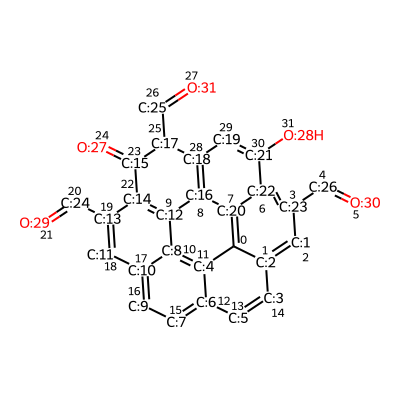

In [20]:
# --- Create RDKit mol from SMILES
mol = Chem.MolFromSmiles(data[0][mol_name])
mol

In [26]:
# --- Set up Bokeh plot settings
p = figure(
    x_axis_label = 'Photon Energy (eV)',
    y_axis_label = 'arb. units',
    x_range = (280, 300),
    width = 500, height = 500,
    outline_line_color = 'black', outline_line_width = 2
)

p.toolbar.logo = None
p.toolbar_location = None
p.min_border = 25

# --- x-axis settings
p.xaxis.ticker.desired_num_ticks = 3
p.xaxis.axis_label_text_font_size = '24px'
p.xaxis.major_label_text_font_size = '24px'
p.xaxis.major_tick_in = 0
p.xaxis.major_tick_out = 10
p.xaxis.minor_tick_out = 6
p.xaxis.major_tick_line_width = 2
p.xaxis.minor_tick_line_width = 2
p.xaxis.major_tick_line_color = 'black'
p.xaxis.minor_tick_line_color = 'black'
# --- y-axis settings
p.yaxis.axis_label_text_font_size = '24px'
p.yaxis.major_tick_line_color = None
p.yaxis.minor_tick_line_color = None
p.yaxis.major_label_text_color = None
# --- grid settings
p.grid.grid_line_color = 'grey'
p.grid.grid_line_alpha = 0.3
p.grid.grid_line_width = 1.5
p.grid.grid_line_dash = "dashed"

In [28]:
# --- Plot similar spectra of similar chemical environments
# --- to check if dictionary is right
x = np.linspace(280, 300, 200)
p.line(x, data[1][mol_name]['15'], line_width=3, line_color='blue')
p.line(x, data[1][mol_name]['13'], line_width=3, line_color='red')
show(p)

In [14]:
export_png(p, filename='atom_spectra.png', width=500, height=500)

'd:\\github\\GO_molecule_GNN\\atom_spectra.png'

In [1]:
bad_mols = ['0','2','7','9','10','12','14','15','16','17','18','22','23','27','31','32','33','36',
            '37','38','41','42','43','46','47','48','50','51','52','53','54','55','56','59','61',
            '62','63','65','67','68','71','74','75','76','78','79','81','84','85','88','89','90']

print(len(bad_mols))

52


In [156]:
good_mols = ['1','3','4','5','6','8','11','13','19','20','21','24','25','26','28','29','30','34',
             '35','39','40','44','45','49','57','58','60','64','66','69','70','72','73','77',
             '80','82','83','86','87']

print(len(good_mols))

39


In [7]:
from ase.visualize import view

In [31]:
path = '../GNN_XAS_Node/raw_data/coronene/OPT_output/R_eOH_1_eCOOH__0_eEPOXY_0_eCHO_3_eKETO_1_iOH_0_iEPOXY_0_ieEPOXY_0_2/OPT_R_eOH_1_eCOOH__0_eEPOXY_0_eCHO_3_eKETO_1_iOH_0_iEPOXY_0_ieEPOXY_0_2.xyz'

In [116]:
go = read(path)

In [117]:
view(go)

<Popen: returncode: None args: ['c:\\Users\\a3782\\AppData\\Local\\anaconda3...>

In [34]:
go.get_atomic_numbers()

array([6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 8, 8, 8, 8, 8, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [35]:
nums = go.get_atomic_numbers()
pos = go.get_positions()

In [36]:
pos[9]

array([ 3.90536412, -0.88084228,  0.52489713])

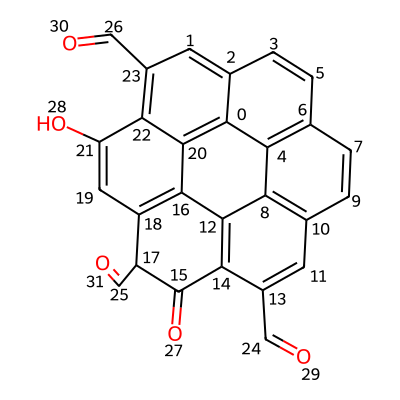

In [104]:
mol = MolFromXYZFile(path)
rdDetermineBonds.DetermineBonds(mol)
mol = Chem.RemoveAllHs(mol)
Chem.RemoveStereochemistry(mol)
mol

In [105]:
for i, atom in enumerate(mol.GetAtoms()):
    atom.SetAtomMapNum(atom.GetIdx())

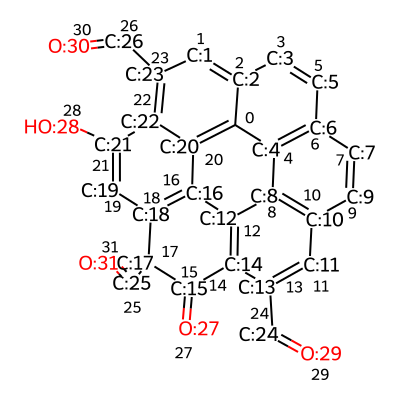

In [106]:
mol

In [107]:
ase_go = read(path)
pos = ase_go.get_positions()
num = ase_go.get_atomic_numbers()

In [108]:
xyz = {}

for i, atom in enumerate(mol.GetAtoms()):
    xyz[atom.GetAtomMapNum()] = atom, pos[i], num[i] 

In [109]:
xyz

{0: (<rdkit.Chem.rdchem.Atom at 0x1f40be2c5f0>,
  array([ 0.29955014,  1.31776084, -0.16723374]),
  6),
 1: (<rdkit.Chem.rdchem.Atom at 0x1f40be2c4a0>,
  array([-0.79167919,  3.47168396, -0.54901948]),
  6),
 2: (<rdkit.Chem.rdchem.Atom at 0x1f40be2c6d0>,
  array([ 0.40034408,  2.73300888, -0.3532483 ]),
  6),
 3: (<rdkit.Chem.rdchem.Atom at 0x1f40be2c740>,
  array([ 1.6741415 ,  3.37666622, -0.33580439]),
  6),
 4: (<rdkit.Chem.rdchem.Atom at 0x1f40be2c7b0>,
  array([1.50141756, 0.56653026, 0.0521042 ]),
  6),
 5: (<rdkit.Chem.rdchem.Atom at 0x1f40be2c820>,
  array([ 2.82892543,  2.64730851, -0.13035156]),
  6),
 6: (<rdkit.Chem.rdchem.Atom at 0x1f40be2c890>,
  array([2.7712467 , 1.23759034, 0.07288762]),
  6),
 7: (<rdkit.Chem.rdchem.Atom at 0x1f40be2c900>,
  array([3.96247106, 0.47723046, 0.30566385]),
  6),
 8: (<rdkit.Chem.rdchem.Atom at 0x1f40be2c970>,
  array([ 1.44091179, -0.84929296,  0.26258775]),
  6),
 9: (<rdkit.Chem.rdchem.Atom at 0x1f40be2c9e0>,
  array([ 3.90536412, -0.

In [110]:
smi = Chem.MolToSmiles(mol)
smi

'c12[c:2]3[cH:1][c:23]([CH:26]=[O:30])[c:22]4[c:20]1[c:16]1[c:12]5[c:8]6[c:4]2[c:6]([cH:5][cH:3]3)[cH:7][cH:9][c:10]6[cH:11][c:13]([CH:24]=[O:29])[c:14]5[C:15](=[O:27])[CH:17]([CH:25]=[O:31])[c:18]1[cH:19][c:21]4[OH:28]'

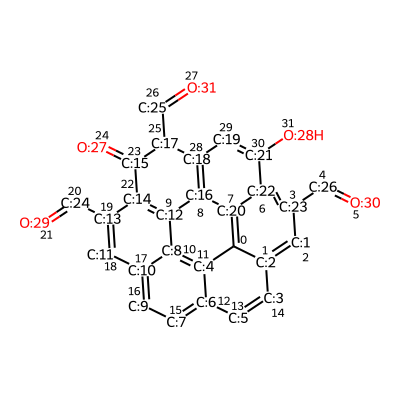

In [111]:
new_mol = Chem.MolFromSmiles(smi)
new_mol

In [112]:
idx_dict = {}
map_num = {}

for atom in new_mol.GetAtoms():
    map_num[atom.GetAtomMapNum()] = atom

In [113]:
sort_map = sorted(map_num)
sort_map

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31]

In [114]:
for num in sort_map:
    rd_idx = map_num[num].GetIdx()
    idx_dict[num] = rd_idx, xyz[num][1], map_num[num].GetAtomicNum()

In [115]:
idx_dict

{0: (0, array([ 0.29955014,  1.31776084, -0.16723374]), 6),
 1: (2, array([-0.79167919,  3.47168396, -0.54901948]), 6),
 2: (1, array([ 0.40034408,  2.73300888, -0.3532483 ]), 6),
 3: (14, array([ 1.6741415 ,  3.37666622, -0.33580439]), 6),
 4: (11, array([1.50141756, 0.56653026, 0.0521042 ]), 6),
 5: (13, array([ 2.82892543,  2.64730851, -0.13035156]), 6),
 6: (12, array([2.7712467 , 1.23759034, 0.07288762]), 6),
 7: (15, array([3.96247106, 0.47723046, 0.30566385]), 6),
 8: (10, array([ 1.44091179, -0.84929296,  0.26258775]), 6),
 9: (16, array([ 3.90536412, -0.88084228,  0.52489713]), 6),
 10: (17, array([ 2.65163992, -1.57668984,  0.51735528]), 6),
 11: (18, array([ 2.58060596, -2.96270853,  0.77729392]), 6),
 12: (9, array([ 0.18035848, -1.53528035,  0.21917498]), 6),
 13: (19, array([ 1.36487481, -3.64597647,  0.77744716]), 6),
 14: (22, array([ 0.15272792, -2.95008269,  0.44985931]), 6),
 15: (23, array([-1.11570836, -3.69004481,  0.30592192]), 6),
 16: (8, array([-1.02646341, -0